In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

In [2]:
N = 1000; Ne = int( 0.8*N ); Ni = int( 0.2*N );

T = 4; # total time we want to simulate, 4 s
dt = 0.001; # 1 ms temporal resolution

time = np.linspace(dt,T, int(T/dt)) # time in ms

In [3]:
# decide which 20% neurons are inhibitory
inhibitory_indx = np.sort(np.random.choice(range(N),Ni,replace=False))
inhibitory_indx

array([  0,   4,   9,  20,  22,  27,  39,  42,  43,  45,  53,  58,  61,
        66,  72,  87,  94,  95,  99, 111, 114, 116, 117, 123, 126, 127,
       128, 130, 132, 134, 135, 143, 144, 148, 150, 151, 154, 155, 156,
       157, 162, 163, 171, 178, 185, 187, 188, 189, 193, 199, 200, 204,
       209, 211, 214, 223, 227, 232, 246, 247, 249, 263, 278, 284, 285,
       288, 299, 300, 302, 322, 326, 331, 334, 344, 347, 349, 354, 364,
       372, 374, 383, 400, 405, 411, 420, 429, 430, 437, 445, 447, 453,
       456, 457, 460, 465, 466, 472, 484, 486, 490, 493, 496, 508, 513,
       517, 518, 521, 529, 537, 538, 546, 547, 550, 552, 556, 557, 559,
       576, 590, 601, 610, 619, 621, 623, 624, 625, 636, 642, 655, 656,
       657, 662, 664, 667, 676, 682, 684, 700, 709, 715, 721, 728, 729,
       738, 740, 744, 746, 747, 748, 750, 752, 755, 759, 763, 768, 778,
       781, 785, 786, 788, 791, 793, 795, 800, 824, 830, 831, 843, 846,
       849, 852, 853, 854, 864, 869, 870, 871, 875, 880, 882, 88

In [4]:
J0 = 0.3; J1 = 0.015; J2 = 0.02; l = 0.15
sigma = 1.8

x0 = time/T
I0 = 1.02
lambda_e = 0.03
lambda_i = 0.02
Vres = 0.85
theta = 1

# i-d array, storing the position of each neuron
# positions = np.linspace(0,1,N,endpoint=False)
positions = np.random.uniform(0,1,N)

# pre-define Jij_ex
Jij_ex = np.zeros([N, N])

In [5]:
def s_in():
    rand = np.random.uniform(0,1,1)
    if rand<0.7:
        return 1
    else:
        return 0
    
def s_ex():
    rand = np.random.uniform(0,1,1)
    if rand<0.2:
        return 1
    else:
        return 0

In [6]:
def sigmoid(x):
    z = 1 / (1 + np.exp(-x))
    return z

In [7]:
# Equ. 8
def sigma_ij_comp(i,j,sigma):
    if i<j:
        result = 1
    else:
        result = sigma
    return result

In [8]:
def Jij_ex_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J1 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

In [9]:
def Jij_in_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J2 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

In [10]:
# compute each element of Jij_ex, treat Jij_ex as a constant matrix
for ii in range(N):
    for jj in range(N):
        Jij_ex[ii,jj] = Jij_ex_comp(ii,jj)
    
Jij_ex

array([[0.027     , 0.01191938, 0.00112099, ..., 0.00024733, 0.00075422,
        0.00264684],
       [0.02145488, 0.027     , 0.00141072, ..., 0.00031126, 0.00094916,
        0.00333093],
       [0.00201778, 0.00253929, 0.027     , ..., 0.00330959, 0.0100923 ,
        0.00635281],
       ...,
       [0.0004452 , 0.00056027, 0.00595726, ..., 0.027     , 0.00491898,
        0.00140168],
       [0.0013576 , 0.00170848, 0.01816613, ..., 0.00885417, 0.027     ,
        0.0042743 ],
       [0.00476431, 0.00599567, 0.01143506, ..., 0.00252302, 0.00769373,
        0.027     ]])

In [11]:
# compute each element of Jij_in, treat Jij_in as a constant matrix
Jij_in = np.zeros([N, N])
for ii in range(N):
    for jj in range(N):
        Jij_in[ii,jj] = Jij_in_comp(ii,jj)
    
Jij_in

array([[0.036     , 0.0158925 , 0.00149465, ..., 0.00032978, 0.00100563,
        0.00352912],
       [0.02860651, 0.036     , 0.00188096, ..., 0.00041501, 0.00126554,
        0.00444124],
       [0.00269038, 0.00338572, 0.036     , ..., 0.00441279, 0.0134564 ,
        0.00847041],
       ...,
       [0.0005936 , 0.00074702, 0.00794302, ..., 0.036     , 0.00655865,
        0.00186891],
       [0.00181014, 0.00227798, 0.02422151, ..., 0.01180556, 0.036     ,
        0.00569906],
       [0.00635241, 0.00799422, 0.01524675, ..., 0.00336403, 0.01025831,
        0.036     ]])

In [12]:
# Equ. 9
I_ext_ex = np.zeros([Ne, len(time)])

for i in range(Ne):
    for t in range(len(time)):
        I_ext_ex[i,t] = I0 * (1 + lambda_e*np.exp(-np.abs(positions[i]-x0[t])/l))
I_ext_ex

array([[1.03543126, 1.035457  , 1.03548279, ..., 1.02007761, 1.02007748,
        1.02007735],
       [1.03226207, 1.03228252, 1.03230301, ..., 1.02009767, 1.02009751,
        1.02009734],
       [1.02115322, 1.02115514, 1.02115707, ..., 1.0210385 , 1.02103677,
        1.02103504],
       ...,
       [1.02050455, 1.02050539, 1.02050624, ..., 1.02237362, 1.02236967,
        1.02236572],
       [1.02006254, 1.02006264, 1.02006275, ..., 1.03915073, 1.03911884,
        1.039087  ],
       [1.02021799, 1.02021835, 1.02021872, ..., 1.02549392, 1.02548477,
        1.02547563]])

In [13]:
# Equ. 10
I_ext_in = np.zeros(len(time))

for t in range(len(time)):
    I_ext_in[t] = I0 * (1 + lambda_i * np.cos(2*np.pi*time[t]*8)) # 6-9 Hz

I_ext_in

array([1.04037423, 1.040297  , 1.0401685 , ..., 1.040297  , 1.04037423,
       1.0404    ])

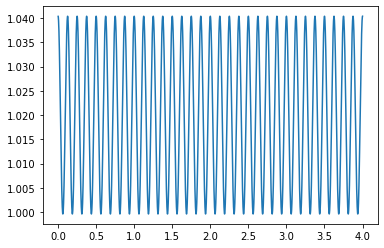

In [14]:
plt.plot(time, I_ext_in)

In [15]:
# I_ext = combine I_ext_ex and I_ext_in
I_ext = np.zeros([N, len(time)])
cnt_ex = 0
cnt_in = 0
for i in range(N):
    if i in inhibitory_indx:
        I_ext[i,:] = I_ext_in
        cnt_in = cnt_in + 1
    else:
        I_ext[i,:] = I_ext_ex[cnt_ex,:]
        cnt_ex = cnt_ex + 1
        

In [16]:
def delta_kronecker(delta_t):
    if delta_t == 0:
        return 1
    else:
        return 0

In [17]:
# compute I_ex and I_in
I_ex = np.zeros([N, len(time)])
I_in = np.zeros([N, len(time)])

t_spike = np.zeros([N, len(time)])

Is = I_ex - I_in

V = np.zeros([N, len(time)])
V[:,0] = Vres

In [18]:
tau_ex = 6/1000
tau_in = 4/1000
tau = 20/1000

In [19]:
# Equ. 3
def integrate_and_fire(V, t_spike_time, t, Is):
    dV = dt*(-V[:,t-1] + Is[:,t-1] + I_ext[:,t-1])/tau
    V[:,t] = V[:,t-1] + dV
    for i in range(N):
        if V[i,t]>theta:
            t_spike_time[i,t] = 1
            V[i,t] = Vres
            
        if i in inhibitory_indx:
            I_in[i,t] = I_in[i,t-1] + dt*(-I_in[i,t-1]/tau_in + s_in()*np.dot(Jij_in[i,:],t_spike_time[:,t-1]))
        else:
            I_ex[i,t] = I_ex[i,t-1] + dt*(-I_ex[i,t-1]/tau_ex + s_ex()*np.dot(Jij_ex[i,:],t_spike_time[:,t-1]))
            
    Is = I_ex - I_in
    
    return V, t_spike_time, Is

In [20]:
for t in range(1,len(time)):
    V, t_spike, Is = integrate_and_fire(V, t_spike, t, Is)
    

In [21]:
t_spike

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

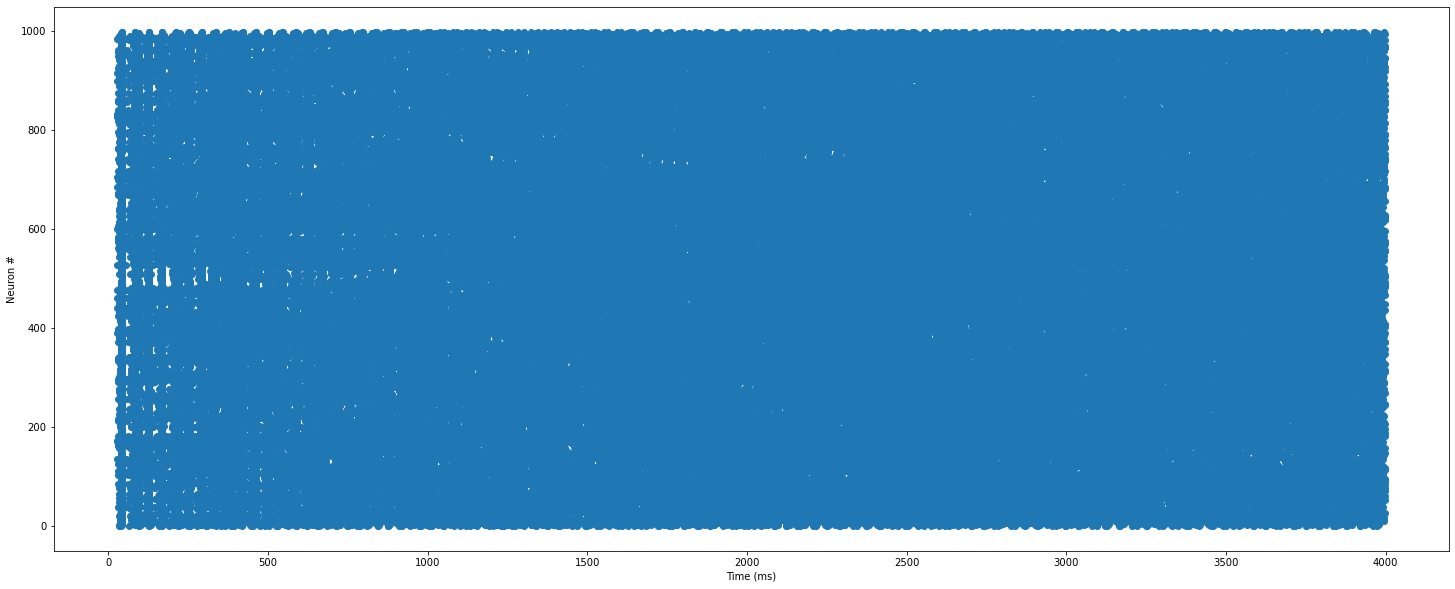

In [22]:
plt.figure(figsize=(25,10))
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spike==1)[1], np.where(t_spike==1)[0])

In [23]:
np.where(t_spike==1)[0]

array([  0,   0,   0, ..., 999, 999, 999])

In [24]:
np.sum(t_spike==1)

104500

In [ ]:
# Figure 2

In [53]:
N = 100
J0 = 0.3; J1 = 0.4; l = 0.2
Jij = np.zeros([N,N])

positions = np.random.uniform(0,1,N)

for i in range(N):
    for j in range(N):
        Jij[i,j] = J1 * np.exp(-np.abs(positions[i]-positions[j])/l) - J0

In [54]:
dt = 0.001; T = 1
time = np.linspace(dt,T,int(T/dt))
r = np.zeros([N, len(time)])
V = np.zeros([N, len(time)])
spikes = np.zeros([N, len(time)])
tau = 20/1000

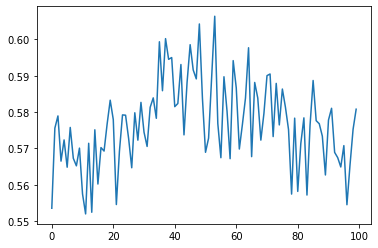

In [55]:
Ie_l = np.linspace(0,0.5,50) * 0.06 + 0.55 + np.random.randn(50) * 0.01 + 0.01
Ie_r = np.linspace(0.5,1,50) * (-0.06) + 0.61 + np.random.randn(50) * 0.01 + 0.01
Ie = numpy.concatenate([Ie_l,Ie_r])
plt.plot(Ie)

In [56]:
def iaf(V, spikes, t, Ie):
    
    for i in range(N):
        r = sigmoid(V[i,:])
        V[i,t] = V[i,t-1] + dt * ( -V[i,t-1] + np.dot(Jij[i,:],r) + Ie)/tau
        if V[i,t]>theta:
            spikes[i,t] = 1
            V[i,t] = Vres
    return V, spikes

In [57]:
for t in range(len(time)):
    V, spikes = iaf(V, spikes, t, Ie)
    
V

ValueError: shapes (100,) and (1000,) not aligned: 100 (dim 0) != 1000 (dim 0)